Silhouette Score (k=35): 0.498


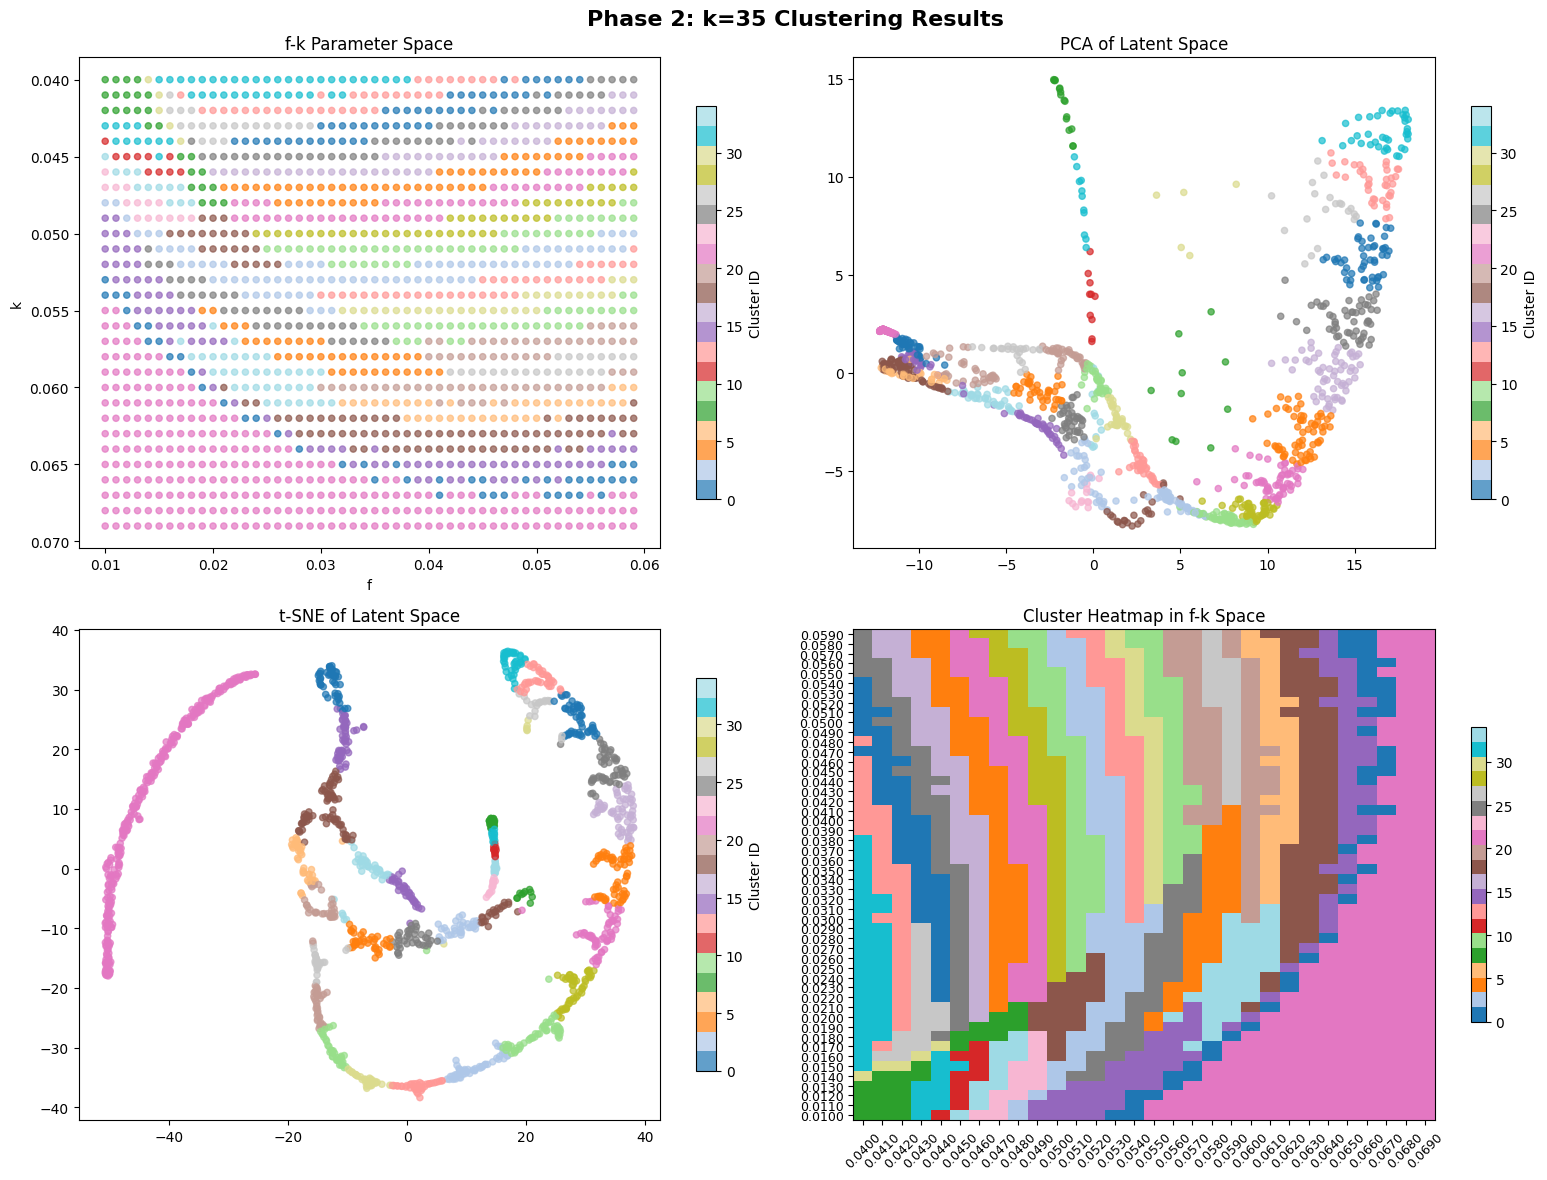

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Google Driveを使う場合は以下を先に実行
# from google.colab import drive
# drive.mount('/content/drive')
# results_path = '/content/drive/MyDrive/GrayScottML/results/analysis_results_phase2.pkl'

results_path = '/Users/miura/_git/GrayScottMachineLearning/results/phase2_results_gpu.pkl'  # パスを適宜修正

with open(results_path, 'rb') as f:
    results = pickle.load(f)

latent_vectors = results['latent_vectors']
f_values = results['f_values']
k_values = results['k_values']

n_clusters = 35
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_vectors)
silhouette = silhouette_score(latent_vectors, cluster_labels)
print(f"Silhouette Score (k=35): {silhouette:.3f}")

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(latent_vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(latent_vectors)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Phase 2: k=35 Clustering Results', fontsize=16, fontweight='bold')

sc1 = axes[0, 0].scatter(f_values, k_values, c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
axes[0, 0].set_xlabel('f')
axes[0, 0].set_ylabel('k')
axes[0, 0].set_title('f-k Parameter Space')
axes[0, 0].invert_yaxis()
plt.colorbar(sc1, ax=axes[0, 0], label='Cluster ID', shrink=0.8)

sc2 = axes[0, 1].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
axes[0, 1].set_title('PCA of Latent Space')
plt.colorbar(sc2, ax=axes[0, 1], label='Cluster ID', shrink=0.8)

sc3 = axes[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
axes[1, 0].set_title('t-SNE of Latent Space')
plt.colorbar(sc3, ax=axes[1, 0], label='Cluster ID', shrink=0.8)

f_unique = np.unique(f_values)
k_unique = np.unique(k_values)
heatmap_data = np.full((len(f_unique), len(k_unique)), np.nan)
for i, f in enumerate(f_values):
    k = k_values[i]
    cluster = cluster_labels[i]
    f_idx = np.where(f_unique == f)[0][0]
    k_idx = np.where(k_unique == k)[0][0]
    heatmap_data[f_idx, k_idx] = cluster
im = axes[1, 1].imshow(heatmap_data, cmap='tab20', aspect='auto', origin='lower', vmin=0, vmax=n_clusters-1)
axes[1, 1].set_title('Cluster Heatmap in f-k Space')
# k, fのユニーク値リスト
f_unique = np.unique(f_values)
k_unique = np.unique(k_values)

# x軸（k）・y軸（f）に実際の値をラベルとして表示
axes[1, 1].set_xticks(range(len(k_unique)))
axes[1, 1].set_yticks(range(len(f_unique)))
axes[1, 1].set_xticklabels([f'{k:.4f}' for k in k_unique], rotation=45, fontsize=9)
axes[1, 1].set_yticklabels([f'{f:.4f}' for f in f_unique], fontsize=9)


plt.colorbar(im, ax=axes[1, 1], shrink=0.6)

plt.tight_layout()
plt.show()

In [11]:
import torch
from torchviz import make_dot
from src.gray_scott_autoencoder_phase2 import Conv3DAutoencoderPhase2

model = Conv3DAutoencoderPhase2(
    input_channels=1, fixed_frames=30, target_size=(64, 64), latent_dim=256
)
model.eval()  # ★ここを追加

x = torch.randn(1, 1, 30, 64, 64)
with torch.no_grad():
    output, latent = model(x)

dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.format = 'png'
dot.render('phase2_network_graph')

'phase2_network_graph.png'

In [14]:
from torchsummary import summary
from src.gray_scott_autoencoder_phase2 import Conv3DAutoencoderPhase2

model = Conv3DAutoencoderPhase2(input_channels=1, fixed_frames=30, target_size=(64, 64), latent_dim=256)
summary(model, (1, 30, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 30, 32, 32]           4,736
       BatchNorm3d-2       [-1, 32, 30, 32, 32]              64
              ReLU-3       [-1, 32, 30, 32, 32]               0
         Dropout3d-4       [-1, 32, 30, 32, 32]               0
            Conv3d-5       [-1, 64, 15, 16, 16]          55,296
       BatchNorm3d-6       [-1, 64, 15, 16, 16]             128
         Dropout3d-7       [-1, 64, 15, 16, 16]               0
            Conv3d-8       [-1, 64, 15, 16, 16]         110,592
       BatchNorm3d-9       [-1, 64, 15, 16, 16]             128
AdaptiveAvgPool3d-10         [-1, 64, 15, 1, 1]               0
           Conv3d-11         [-1, 16, 15, 1, 1]           1,040
             ReLU-12         [-1, 16, 15, 1, 1]               0
           Conv3d-13         [-1, 64, 15, 1, 1]           1,088
          Sigmoid-14         [-1, 64, 1

In [16]:
from torchsummary import summary
from src.gray_scott_autoencoder_phase2 import Conv3DAutoencoderPhase2

model = Conv3DAutoencoderPhase2(input_channels=1, fixed_frames=30, target_size=(64, 64), latent_dim=256)
summary(model, (1, 30, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 30, 32, 32]           4,736
       BatchNorm3d-2       [-1, 32, 30, 32, 32]              64
              ReLU-3       [-1, 32, 30, 32, 32]               0
         Dropout3d-4       [-1, 32, 30, 32, 32]               0
            Conv3d-5       [-1, 64, 15, 16, 16]          55,296
       BatchNorm3d-6       [-1, 64, 15, 16, 16]             128
         Dropout3d-7       [-1, 64, 15, 16, 16]               0
            Conv3d-8       [-1, 64, 15, 16, 16]         110,592
       BatchNorm3d-9       [-1, 64, 15, 16, 16]             128
AdaptiveAvgPool3d-10         [-1, 64, 15, 1, 1]               0
           Conv3d-11         [-1, 16, 15, 1, 1]           1,040
             ReLU-12         [-1, 16, 15, 1, 1]               0
           Conv3d-13         [-1, 64, 15, 1, 1]           1,088
          Sigmoid-14         [-1, 64, 1